In [6]:
! pip install opencv-python

In [7]:
import cv2
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, concatenate

In [8]:
def load_spectrogram_images(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, color_mode='grayscale', target_size=(128, 128))  # Adjust target_size as needed
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

In [9]:
df = pd.read_csv('audio_feature_file.csv')
image_paths = ['.\\melspectrogram\\' + os.path.basename(fname).replace('.wav', '.png') for fname in df['audio_path']]
spectrogram_images = load_spectrogram_images(image_paths)
print(type(spectrogram_images))

<class 'numpy.ndarray'>


In [10]:
X_spectrograms = spectrogram_images
target = df['target']
df.drop(columns=['audio_path'], inplace=True)
X_features = df

In [11]:
print(X_spectrograms.shape)
print(X_features.shape)

(1441, 128, 128, 1)
(1441, 50)


In [12]:
y = target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print("targert : ",y.shape)
num_classes = len(np.unique(target))
print("num_classes : ",num_classes)

targert :  (1441, 5)
num_classes :  5


In [13]:
def multi_channel_cnn(input_shape_spectrogram, input_shape_features, num_classes):
    # Spectrogram channel
    input_spectrogram = Input(shape=input_shape_spectrogram)
    x_spectrogram = Conv2D(32, kernel_size=(3, 3), activation='relu')(input_spectrogram)
    x_spectrogram = MaxPooling2D(pool_size=(2, 2))(x_spectrogram)
    x_spectrogram = Conv2D(64, kernel_size=(3, 3), activation='relu')(x_spectrogram)
    x_spectrogram = MaxPooling2D(pool_size=(2, 2))(x_spectrogram)
    x_spectrogram = Conv2D(128, kernel_size=(3, 3), activation='relu', name='last_conv_layer')(x_spectrogram)
    x_spectrogram = MaxPooling2D(pool_size=(2, 2))(x_spectrogram)
    x_spectrogram = Flatten()(x_spectrogram)
    
    # Features channel
    input_features = Input(shape=input_shape_features)
    x_features = Dense(128, activation='relu')(input_features)
    
    # Combine channels
    combined = concatenate([x_spectrogram, x_features])
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(num_classes, activation='softmax')(combined)
    
    model = Model(inputs=[input_spectrogram, input_features], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
! pip install pydot graphviz


In [19]:
from tensorflow.keras.utils import plot_model

# Save the model architecture to a file
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [16]:
# Define input shapes and number of classes
input_shape_spectrogram = X_spectrograms[0].shape
input_shape_features = (X_features.shape[1],)
num_classes = 5

# Create and summarize the model
model = multi_channel_cnn(input_shape_spectrogram, input_shape_features, num_classes)
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last_conv_layer     │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ last_conv_layer[… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      6,528 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 25216)     │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │  3,227,776 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        645 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,327,621 (12.69 MB)

 Trainable params: 3,327,621 (12.69 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
! pip uninstall pydot
! pip install pydot

^C


In [25]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Replace with your Graphviz bin path

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model
from PIL import Image
import matplotlib.pyplot as plt

# Save the model architecture to a file
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Load the image
img = Image.open('model.png')

# Display the image
plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.show()


AttributeError: module 'pydot' has no attribute 'InvocationException'

In [21]:
! dot -V


'dot' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
X = list(zip(X_spectrograms, X_features.values))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)
X_left = np.array([t[0] for t in X_train], dtype=np.float32)
X_right = np.array([t[1] for t in X_train], dtype=np.float32)
X_test_left = np.array([t[0] for t in X_test], dtype=np.float32)
X_test_right = np.array([t[1] for t in X_test], dtype=np.float32)

In [ ]:
# Train the model
history =model.fit([X_spectrograms, X_features], y, validation_split=0.2, epochs=50, batch_size=16)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 40s 508ms/step - accuracy: 0.3905 - loss: 25.9923 - val_accuracy: 0.5744 - val_loss: 1.1211
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 454ms/step - accuracy: 0.5392 - loss: 1.2524 - val_accuracy: 0.6332 - val_loss: 1.1555
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 436ms/step - accuracy: 0.5588 - loss: 1.1731 - val_accuracy: 0.6574 - val_loss: 0.9799
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 31s 432ms/step - accuracy: 0.5670 - loss: 1.1396 - val_accuracy: 0.6574 - val_loss: 0.9869
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 28s 385ms/step - accuracy: 0.6123 - loss: 1.0270 - val_accuracy: 0.6471 - val_loss: 0.8581
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 403ms/step - accuracy: 0.6125 - loss: 0.9875 - val_accuracy: 0.6644 - val_loss: 0.8466
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 38s 352ms/step - accuracy: 0.6131 - loss: 0.9854 - val_accuracy: 0.6505 - val_loss: 0.8758
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 513ms/step - accuracy: 0.6484 - loss: 0.9361 - val_acc

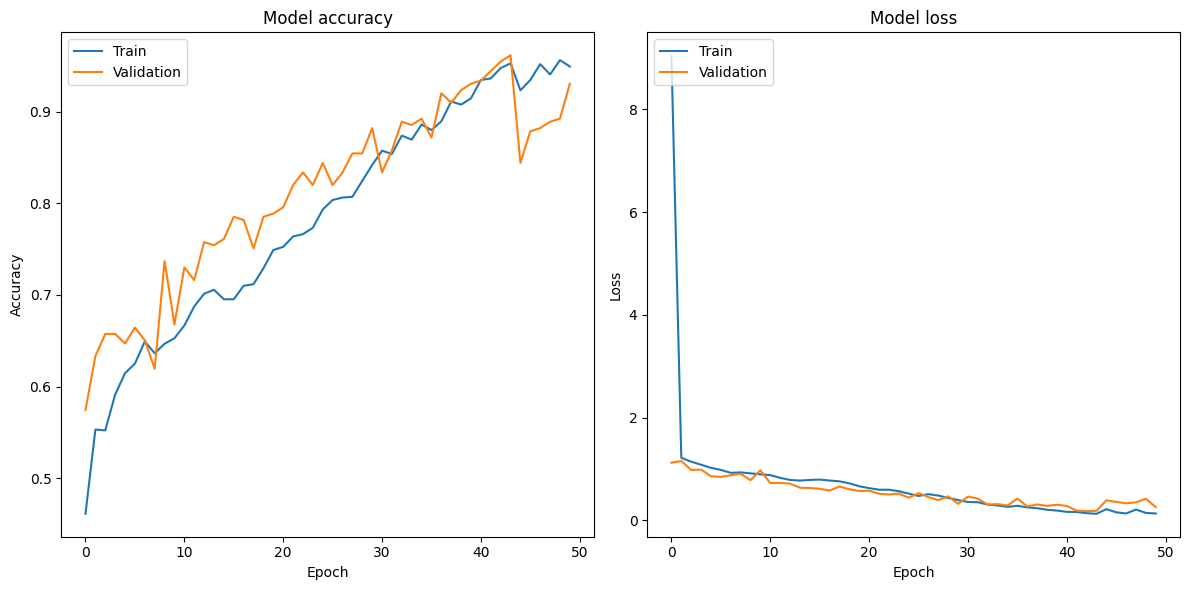

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
print(X_spectrograms.shape)
print(X_features.shape)
print(y_test.shape)


(1441, 128, 128, 1)
(1441, 50)
(289, 5)


In [ ]:
min_samples = min(len(X_spectrograms), len(X_features), len(y))

X_spectrograms = X_spectrograms[:min_samples]
X_features = X_features[:min_samples]
y = y[:min_samples]

print("After trimming:")
print("X_spectrograms shape:", X_spectrograms.shape)
print("X_features shape:", X_features.shape)
print("y shape:", y.shape)


After trimming:
X_spectrograms shape: (289, 128, 128, 1)
X_features shape: (289, 50)
y shape: (289, 5)


In [ ]:
from sklearn.model_selection import train_test_split

X_spectrograms_train, X_spectrograms_test, X_features_train, X_features_test, y_train, y_test = train_test_split(
    X_spectrograms, X_features, y, test_size=0.2, random_state=42)

print("Shapes after train-test split:")
print("X_spectrograms_train shape:", X_spectrograms_train.shape)
print("X_spectrograms_test shape:", X_spectrograms_test.shape)
print("X_features_train shape:", X_features_train.shape)
print("X_features_test shape:", X_features_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)



Shapes after train-test split:
X_spectrograms_train shape: (231, 128, 128, 1)
X_spectrograms_test shape: (58, 128, 128, 1)
X_features_train shape: (231, 50)
X_features_test shape: (58, 50)
y_train shape: (231, 5)
y_test shape: (58, 5)


In [ ]:

loss, accuracy = model.evaluate([X_spectrograms_test, X_features_test], y_test)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate([X_spectrograms_train,X_features_train], y_train)
print('Train loss:', train_loss)
print('Train accuracy:', train_accuracy)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 797ms/step - accuracy: 0.9781 - loss: 0.0324
Test loss: 0.027343638241291046
Test accuracy: 0.982758641242981
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.9725 - loss: 0.0535
Train loss: 0.04468527063727379
Train accuracy: 0.9783549904823303


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, hamming_loss
# Make predictions
y_pred = model.predict([X_spectrograms_test, X_features_test])

# Convert predictions to binary (assuming multi-class one-hot encoded labels)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)
print("Accuracy: ", accuracy)

# Calculate precision
precision = precision_score(y_test, y_pred_binary, average='weighted')
print("Precision: ", precision)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_binary, average='weighted')
print("F1 Score: ", f1)

# Calculate Hamming Loss
hamming = hamming_loss(y_test, y_pred_binary)
print("Hamming Loss: ", hamming)

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
Accuracy:  0.9827586206896551
Precision:  0.9832810867293627
F1 Score:  0.9816597195907542
Hamming Loss:  0.006896551724137931


In [ ]:
# model.save('heartbeat_feature_model.h5')
model.save('multichannel_model.keras')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = tf.keras.preprocessing.image.load_img(img_path, color_mode='grayscale')
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)

    img = plt.imread(cam_path)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

# Example usage
model = tf.keras.models.load_model('multichannel_model.keras')
# audio_path = 'path_to_audio_file.wav'
image_path = '.\\melspectrogram\\extrastole__207_1308159792607_B.png'
spectrogram = load_spectrogram_images(image_path)
features = X_features.iloc[1000].values

img_array = np.array([spectrogram])
img_array_features = np.array([features])

# Generate the Grad-CAM heatmap
heatmap = make_gradcam_heatmap([img_array, img_array_features], model, last_conv_layer_name='last_conv_layer')

# Display the heatmap
display_gradcam(image_path, heatmap)


PermissionError: [Errno 13] Permission denied: '.'